# Chuẩn bị môi trường

In [4]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader

# Huấn luyện, đánh giá và kiểm thử

## Variables và Hyperparameters

In [1]:
training = 'train.csv'
validation = 'validate.csv'
testing = 'test.csv'
epochs = 45
batch_size = 32
learning_rate = 0.001

## Công cụ tải dữ liệu

In [2]:
def loader(file, batch_size):
    dataframe = pd.read_csv(file)
    tensor = torch.tensor(dataframe.values, dtype=torch.float32)
    del dataframe

    return DataLoader(tensor, batch_size, shuffle=False)

## Xây dựng mô hình

### Khởi tạo mô hình

In [5]:
# Defining the Neural Network
class SparseAE(nn.Module):
    def __init__(self, sparsity_param=0.08, beta=0.004):
        super(SparseAE, self).__init__()
        self.sparsity_param = sparsity_param # p hat
        self.beta = beta # To adjust the sparsity penalty

        # Starting point consisting of:
        # 1 input layer
        # 2 hidden layer
        # Modification capacity in exchange of interpretability
        
        self.encoder = nn.Sequential(
            nn.Linear(49, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 49),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

### Khởi tạo hàm mất mát tổng

In [6]:
def cost_function_reconstruct(decoded, input_data, encoded, beta=0.1, rho=0.05):
    mse_loss = F.mse_loss(decoded, input_data)

    epsilon = 1e-8
    rho_hat = torch.mean(encoded, dim=0)
    kl_divergence = torch.sum(
        rho * torch.log(rho / (rho_hat + epsilon)) + 
        (1 - rho) * torch.log((1 - rho) / (1 - rho_hat + epsilon))
    )

    return mse_loss, kl_divergence, mse_loss + beta * kl_divergence

### Khởi tạo quy trình Train - Validate - Test

In [16]:
def training_loop(train_dataloader, model, total_cost_function, optimizer, device):
    model.train()
    train_total_loss = 0.0
    train_total_mse = 0.0
    train_total_sparsity = 0.0
    train_total_samples = 0
    for batch in train_dataloader:
        inputs = batch[0].to(device)
        batch_size = inputs.size(0)
        train_total_samples += batch_size
        optimizer.zero_grad()
        encoded, decoded = model(inputs)
        mse_loss, sparsity, total_loss = total_cost_function(
            decoded=decoded,
            input_data=inputs,
            encoded=encoded,
            beta=model.beta,
            rho=model.sparsity_param,
        )
        total_loss.backward()
        optimizer.step()
        train_total_loss += total_loss.item() * batch_size
        train_total_mse += mse_loss.item() * batch_size
        train_total_sparsity += sparsity.item() * batch_size
    avg_train_total = train_total_loss / train_total_samples
    avg_train_mse = train_total_mse / train_total_samples
    avg_train_sparsity = train_total_sparsity / train_total_samples
    return (
        avg_train_total,
        avg_train_mse,
        avg_train_sparsity,
    )

In [20]:
def validation_loop(validate_dataloader, model, total_cost_function, device):
    model.eval()
    val_total_loss = 0.0
    val_total_mse = 0.0
    val_total_sparsity = 0.0
    val_total_samples = 0
    with torch.no_grad():
        for batch in validate_dataloader:
            inputs = batch[0].to(device)
            batch_size = inputs.size(0)
            val_total_samples += batch_size
            encoded, decoded = model(inputs)
            mse_loss, sparsity, total_loss = total_cost_function(
                decoded=decoded,
                input_data=inputs,
                encoded=encoded,
                beta=model.beta,
                rho=model.sparsity_param,
            )
            val_total_loss += total_loss.item() * batch_size
            val_total_mse += mse_loss.item() * batch_size
            val_total_sparsity += sparsity.item() * batch_size
    avg_val_total = val_total_loss / val_total_samples
    avg_val_mse = val_total_mse / val_total_samples
    avg_val_sparsity = val_total_sparsity / val_total_samples
    return (
        avg_val_total,
        avg_val_mse,
        avg_val_sparsity,
    )

In [18]:
def testing_loop(test_dataloader, model, total_cost_function, device):
    model.eval()
    test_total_loss = 0.0
    test_total_mse = 0.0
    test_total_sparsity = 0.0
    test_total_samples = 0
    with torch.no_grad():
        for batch in test_dataloader:
            inputs = batch[0].to(device)
            batch_size = inputs.size(0)
            test_total_samples += batch_size
            encoded, decoded = model(inputs)
            mse_loss, sparsity, total_loss = total_cost_function(
                decoded=decoded,
                input_data=inputs,
                encoded=encoded,
                beta=model.beta,
                rho=model.sparsity_param,
            )
            test_total_loss += total_loss.item() * batch_size
            test_total_mse += mse_loss.item() * batch_size
            test_total_sparsity += sparsity.item() * batch_size
    avg_test_total = test_total_loss / test_total_samples
    avg_test_mse = test_total_mse / test_total_samples
    avg_test_sparsity = test_total_sparsity / test_total_samples
    return (
        avg_test_total,
        avg_test_mse,
        avg_test_sparsity,
    )

## Chạy mô hình

In [37]:
def activate(training, validation, testing, 
             batch_size, learning_rate, epochs):
    X_train = loader(file=training, batch_size=batch_size)
    print("Training set loaded successfully")
    X_validate = loader(file=validation, batch_size=batch_size)
    print("Validation set loaded successfully")
    X_test = loader(file=testing, batch_size=batch_size)
    print("Testing set loaded successfully\n")

    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
    print(f"Current device: {device}\n")
    
    model = SparseAE()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    print("Initializing training and validation loop with detailed monitoring...")
    for epoch in range(epochs):
        avg_train_total, avg_train_mse, avg_train_sparsity = training_loop(
            X_train, model, cost_function_reconstruct, optimizer, device,
        )

        avg_val_total, avg_val_mse, avg_val_sparsity = validation_loop(
            X_validate, model, cost_function_reconstruct, device,
        )
        print(f"Epoch [{epoch+1}/{epochs}]:")
        print(f"  Average MSE Loss      - Train: {avg_train_mse:.5f}, Validate: {avg_val_mse:.5f}")
        print(f"  Average Sparsity      - Train: {avg_train_sparsity:.5f}, Validate: {avg_val_sparsity:.5f}")
        print(f"  Average Total Cost    - Train: {avg_train_total:.5f}, Validate: {avg_val_total:.5f}")
        print(f"  Rho Target: {model.sparsity_param}\n")
    
    print("Initializing testing process...")
    test_total, test_mse, test_sparsity = testing_loop(
        X_test, model, cost_function_reconstruct, device
    )
    print("Testing process completed")
    print("---- Final Test Result ----")
    print(f"  Test MSE:       {test_mse:.5f}")
    print(f"  Test Sparsity:  {test_sparsity:.5f}")
    print(f"  Test Total:     {test_total:.5f}")    
    return model

In [38]:
trained_model = activate(
    training=training,
    validation=validation,
    testing=testing,
    batch_size=batch_size,
    learning_rate=learning_rate,
    epochs=epochs,
)

Training set loaded successfully
Validation set loaded successfully
Testing set loaded successfully

Current device: cuda

Initializing training and validation loop with detailed monitoring...
Epoch [1/45]:
  Average MSE Loss      - Train: 0.07416, Validate: 0.07275
  Average Sparsity      - Train: 0.11952, Validate: 0.10802
  Average Total Cost    - Train: 0.07464, Validate: 0.07319
  Rho Target: 0.08



KeyboardInterrupt: 

## Đánh giá các thông số

Cả ba thông số có sự thuyên giảm đều thông qua mỗi lần lặp và chỉ số "thưa thớt" thực tế của mô hình ***thấp hơn rất nhiều*** so với chỉ số "thưa thớt" mong đợi (rho hat), cụ thể hơn:
- **MSE Loss** trung bình cho mỗi epoch của bộ Test được cải thiện khoảng 33% (0.08681 -> 0.05799)
- **Sparsity rate** thông qua mỗi lần lặp của từng epoch có sự cải thiện lớn, xấp xỉ 46% (0.00327 -> 0.00177)
- **Phương sai trung bình** giảm đều với sự cải thiện rõ rệt, khoảng 33% (0.08714 -> 0.0581)

Các metric không có sự giao động đột ngột; mỗi metric đều có sự tăng dần thông số với thứ tự Train -> Validate -> Test hợp lý; thông qua từng epoch, các chỉ số phương sai giảm đều không có bước nhảy vọt nào lớn

**->** Mô hình không bị overfitting hay underfitting


Như đã được đề cập, chỉ số thưa thớt (sparsity) thực tế của mô hình chỉ chiếm hệ số  rất nhỏ của chỉ số thưa thớt mong đợi (rho hat), chỉ 3.54% ở bộ Test

**->** Mô hình giữ được tính chất "thưa thớt" đặc trưng, cùng với đó là khả năng học và xử lý dữ liệu một cách tối ưu

Giá trị mất mát tổng trung bình có sự đồng nhất giữa các set thông qua sự bám sát với chỉ số mất mát MSE

**->** Thể hiện rằng công thức hàm mất mát tổng, cấu tạo từ tổng của MSE Loss và Sparsity Penalty, thực hiện tính toán đúng

# Lưu các parameter

In [11]:
PATH = "SparseAutoencoderTuned.pt"
torch.save(trained_model.state_dict(), PATH)

# Load mô hình

In [7]:
trained_model = SparseAE()
PATH = 'SparseAutoencoderFeatureFixed.pt'
trained_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Gán nhãn

## Trích xuất MSE và Features

In [ ]:
def mse_feature_extractor(model, dataloader, device):
    model.to(device)
    model.eval()
    mse_rates = []

    with torch.no_grad():
        for batch in dataloader:            
            input_data = batch.to(device)
            _, decoded = model(input_data)

            error = torch.mean((decoded - input_data)**2, dim=1)
            mse_rates.extend(error.cpu().numpy())
    all_errors = np.array(mse_rates)
    return all_errors

In [9]:
X_train = pd.read_csv('train.csv')
X_validate = pd.read_csv('validate.csv')
X_test = pd.read_csv('test.csv')

X = pd.concat([X_train, X_validate, X_test], ignore_index=True)

In [10]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
X_dataloader = DataLoader(X_tensor, batch_size=50, shuffle=False)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

trained_model.to(device)

SparseAE(
  (encoder): Sequential(
    (0): Linear(in_features=49, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=49, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
mse_rate, encoded_features = mse_feature_extractor(model=trained_model, dataloader=X_dataloader, device=device)

In [13]:
mse_rate_df = pd.DataFrame(mse_rate, columns=['MSE_rate'])
encoded_features_df = pd.DataFrame(encoded_features, columns=['encoded_0', 'encoded_1', 'encoded_2', 'encoded_3',
                                                              'encoded_4', 'encoded_5', 'encoded_6', 'encoded_7'])

## Quan sát sự phân bổ của MSE

### Khởi tạo các hàm cần thiết

In [14]:
def boxplot_drawing(dataframe: object, 
                    column_name: str, 
                    log_scale=None) -> object:
    plt.figure(figsize=(7, 4))
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.boxplot(x=dataframe[column_name], 
                color= '#ED9C9C', 
                log_scale=log_scale)
    plt.title(f'Box Plot of {column_name}')
    plt.xlabel(f'Range of {column_name} ')
    plt.ylabel(f'Distribution of {column_name}')
    plt.tight_layout()
    plt.show()

def histplot_drawing(dataframe: object, 
                     column_name: str, 
                     bins='auto', 
                     log_scale=None) -> object:
    plt.figure(figsize=(8, 4))
    plt.style.use('ggplot')
    sns.histplot(data=dataframe, 
                 x=column_name, 
                 bins=bins, 
                 color='#2093DF', 
                 kde=True, 
                 log_scale=log_scale)
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(f'{column_name}')
    plt.ylabel(f'Range of {column_name}')
    plt.show()

In [15]:
def summary_table_creation(numerical_columns: list, 
                           dataframe: object) -> object:
    
    numerical_dataframe = dataframe[numerical_columns]

    summary_table = numerical_dataframe.describe().transpose()
    summary_table = summary_table.rename(columns={'50%': 'median'})
    summary_table['null_counts'] = numerical_dataframe.isnull().sum()
    summary_table['skewness'] = numerical_dataframe.skew()
    summary_table['kurtosis'] = numerical_dataframe.kurtosis()
    summary_table['cv'] = (summary_table['std'] / summary_table['mean']) * 100
    
    return summary_table

In [16]:
def find_outliers_iqr(data_series):
        Q1 = data_series.quantile(0.25)
        Q3 = data_series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data_series[(data_series < lower_bound) | (data_series > upper_bound)]
        return outliers

### Tính phân bổ của các điểm dữ liệu

In [17]:
summary_table_creation(numerical_columns=['MSE_rate'], dataframe=mse_rate_df)

,count,mean,std,min,25%,median,75%,max,null_counts,skewness,kurtosis,cv
MSE_rate,477829.0,0.054966,0.02919,0.006761,0.032492,0.050599,0.069428,0.270539,0,1.499237,3.784813,53.105844


In [18]:
outlier_number = len(find_outliers_iqr(data_series=mse_rate_df['MSE_rate']))
print(f"The total number of outliers measured: {outlier_number}")
print(f"The ratio of outlier: {outlier_number / len(mse_rate_df) * 100:.4f}%")

The total number of outliers measured: 13779
The ratio of outlier: 2.8837%


### Trực quan hóa

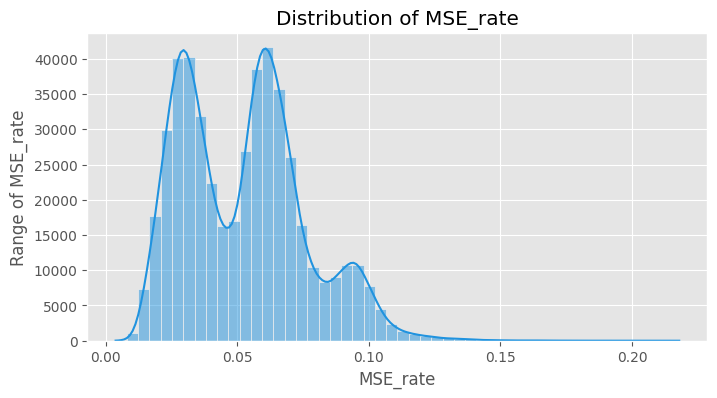

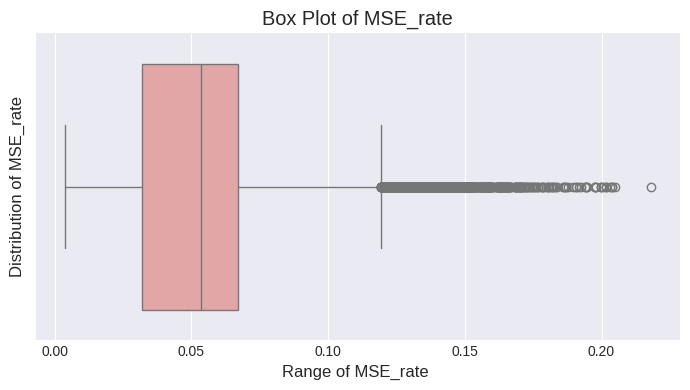

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

histplot_drawing(dataframe=mse_rate_df, column_name='MSE_rate', bins=50)
boxplot_drawing(dataframe=mse_rate_df, column_name='MSE_rate')

In [30]:
len(mse_rate_df[mse_rate_df['MSE_rate'] > 0.1]) / len(mse_rate_df)

0.0318879766611068

### Kết luận tổng quan

Tổng số dòng dữ liệu chỉ số `MSE` được trả về là trùng khớp với chiều của input (tổng dữ liệu gốc) **->** Mô hình được xây dựng đúng, thực hiện đầy đủ các chức năng đặc trưng khi đưa ra kết quả chính xác về mặt cấu trúc.

Trị số `Min` và `Max` cách xa nhau; có xuất hiện outlier rõ rệt từ sự chênh lệch; chỉ số `Standard Deviation` không cách xa `Mean` **->** Không có nhiều điểm tập trung ngoài khu vực khoảng giữa. Ngoài ra, hình dạng của sự phân bố có thể sẽ thuôn dài đều, với chiều cao giảm dần theo chiều lệch mà không có sự biến dạng.

Khoảng cách từ `Mean` đến đầu cuối của mức phổ biến 75% là nhỏ (chỉ khoảng **0.007**) **->** Cần lựa chọn threshold cẩn thận, việc phân định giữa True và False trong Fraud trở nên khó khăn hơn khi khoảng cách giữa các điểm dữ liệu rất thấp.

Chỉ số `Skew` thấp, nhưng vẫn thể hiện dữ liệu có thể bị lệch phải nhẹ với chiều cao bẹt khi `Kurtosis` không cao **->** Phản ánh hợp lý sự phân bổ khi đối chiếu với `Min`/`Max`, dấu hiệu tích cực cho thấy mô hình có vẻ đã đánh dấu được những điểm dữ liệu có giá trị bất thường khi cho ra chỉ số MSE cao vượt trội cho những giá trị này.

Đánh giá dữ liệu trực quan:
- **Histogram:** Chứng mình giả thiết về sự lệch phải nhẹ của dữ liệu. Sự phân bố hình thành hai điểm tập trung chủ yếu là xung quanh **0.05** đến xấp xỉ khoảng **0.075** (thể hiện ngưỡng MSE "bình thường"). Số lượng giá trị bắt đầu thuyên giảm khi sự phân bố bắt đầu từ **0.1** về sau.
- **Box Plot:** Thể hiện sự hiện diện của các outlier một cách rõ ràng hơn. Ngưỡng phân bổ "bình thường" được thể hiện: [0.01, 0.125] và nằm ngoài khoảng cách này thể hiện các giao dịch có thể thuộc phân loại tình nghi hoặc gian lận.

# Phân tách và xuất dữ liệu

## Phân tách dữ liệu

In [28]:
X = pd.concat([encoded_features_df, mse_rate_df], axis=1)

In [31]:
dataset_total_len = len(X)
train_end_idx = int(dataset_total_len * 0.7)
validation_end_idx = int(dataset_total_len * 0.85)

X_train = pd.DataFrame(X.iloc[:train_end_idx])
X_validate = pd.DataFrame(X.iloc[train_end_idx:validation_end_idx])
X_test = pd.DataFrame(X.iloc[validation_end_idx:])

print(f"Training set: {X_train.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Validating set: {X_validate.shape}")

Training set: (334480, 9)
Testing set: (71675, 9)
Validating set: (71674, 9)


In [23]:
X = pd.concat([X, mse_rate_df], axis=1)

## Xuất dữ liệu

In [53]:
encoded_features_df.to_csv('X_encoded.csv', index=False)
mse_rate_df.to_csv('MSE_rate.csv', index=False)

In [26]:
X.to_csv('X_mse_2.csv', index=False)